In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/5_AIADVANCE')

In [3]:
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report , confusion_matrix
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('fivethirtyeight')
%matplotlib inline

# Defining the parameters
batch_size = 32
num_classes = 10
epochs = 50

In [4]:
# Tải mô hình
mobileNetV2 = tf.keras.models.load_model("mobileNetV2_model")

1/1 [==============================] - 3s 3s/step
Giá trị dự đoán:  0


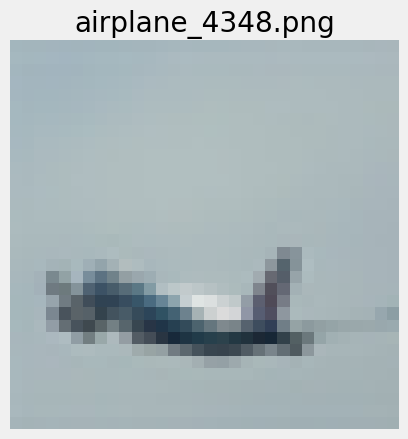

1/1 [==============================] - 0s 147ms/step
Giá trị dự đoán:  1


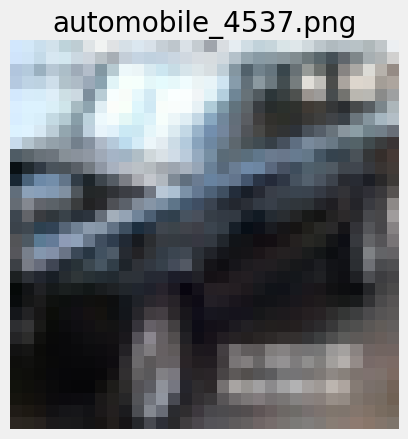

1/1 [==============================] - 0s 166ms/step
Giá trị dự đoán:  2


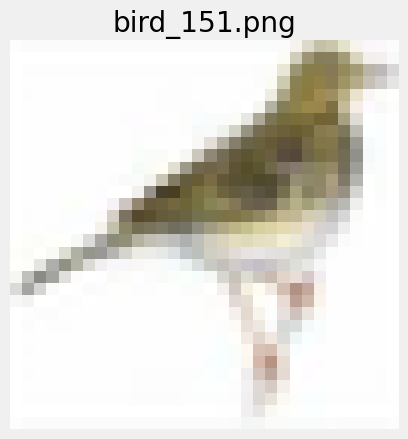

1/1 [==============================] - 0s 142ms/step
Giá trị dự đoán:  3


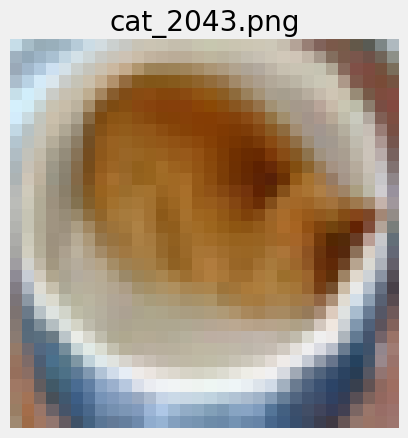

1/1 [==============================] - 0s 148ms/step
Giá trị dự đoán:  4


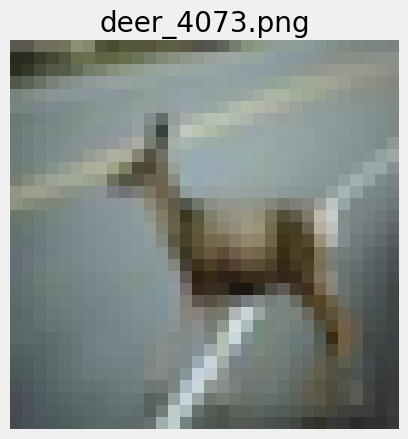

1/1 [==============================] - 0s 156ms/step
Giá trị dự đoán:  5


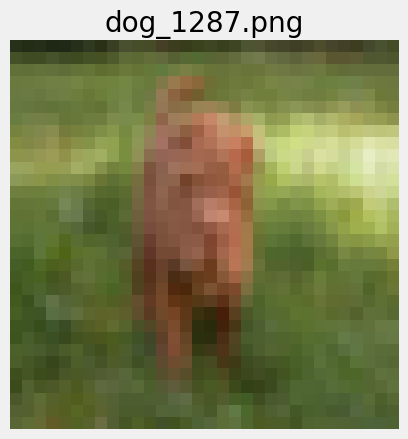

1/1 [==============================] - 0s 144ms/step
Giá trị dự đoán:  6


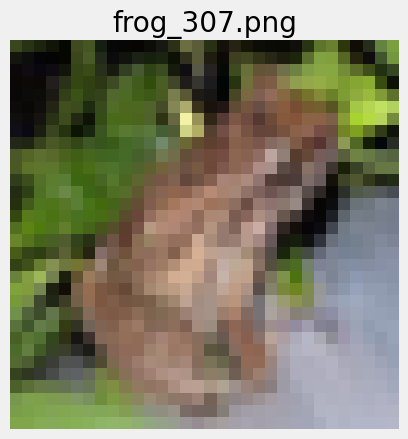

1/1 [==============================] - 0s 148ms/step
Giá trị dự đoán:  7


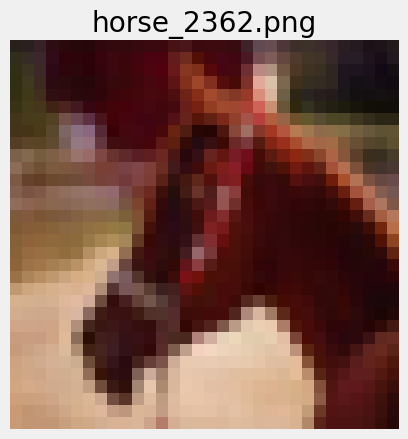

1/1 [==============================] - 0s 154ms/step
Giá trị dự đoán:  8


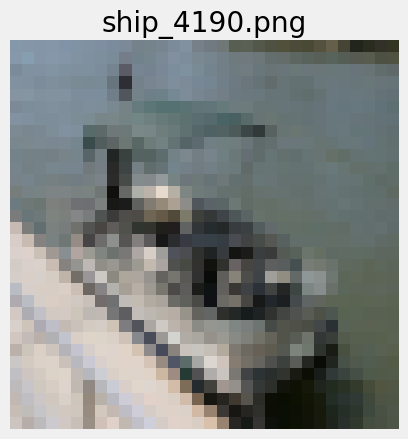

1/1 [==============================] - 0s 144ms/step
Giá trị dự đoán:  9


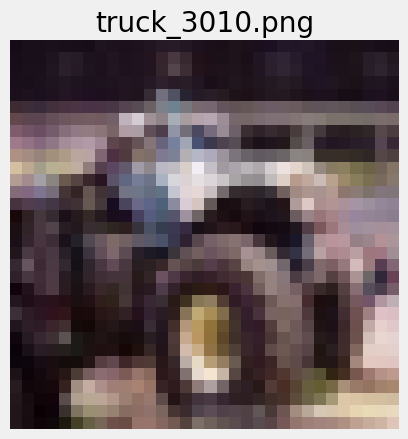

In [13]:
from PIL import Image
import os
import cv2

# Đường dẫn đến thư mục chứa các ảnh đã lưu
saved_images_dir = "./saved_images/"

# Lặp qua từng tệp trong thư mục
for filename in os.listdir(saved_images_dir):
    # Đường dẫn đầy đủ của tệp
    filepath = os.path.join(saved_images_dir, filename)

    # Đọc ảnh từ tệp
    img = Image.open(filepath)
    img = np.array(img)
    img = cv2.resize(img, (32, 32))

    # # Chuyển đổi ảnh về dạng mảng numpy và chuẩn hóa về đoạn [0, 1]
    # img.astype('float32')
    img_array = np.array(img) / 255.0
    # Hiển thị ảnh hoặc thực hiện các thao tác tiếp theo tùy ý

    # Ví dụ: hiển thị ảnh
    plt.imshow(img)
    y_predict = mobileNetV2.predict(np.expand_dims(img_array, axis=0))
    print('Giá trị dự đoán: ', np.argmax(y_predict))
    plt.title(filename)
    plt.axis('off')
    plt.show()

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

class Block(tf.keras.Model):
    def __init__(self, in_channels, out_channels, expansion, strides):
        super(Block, self).__init__()
        self.strides = strides
        channels = expansion * in_channels

        self.conv1 = layers.Conv2D(channels, kernel_size=1, use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(channels, kernel_size=3, strides=strides, padding='same',
                                   groups=channels, use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(out_channels, kernel_size=1, use_bias=False)
        self.bn3 = layers.BatchNormalization()

        if strides == 1 and in_channels != out_channels:
            self.shortcut = tf.keras.Sequential([
                layers.Conv2D(out_channels, kernel_size=1, use_bias=False),
                layers.BatchNormalization()
            ])
        else:
            self.shortcut = lambda x: x

    def call(self, x):
        out = tf.keras.activations.relu(self.bn1(self.conv1(x)))
        out = tf.keras.activations.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = layers.add([self.shortcut(x), out]) if self.strides==1 else out
        return out

class MobileNetV2(tf.keras.Model):
    config = [(1, 16, 1, 1),
              (6, 24, 2, 1),
              (6, 32, 3, 2),
              (6, 64, 4, 2),
              (6, 96, 3, 1),
              (6, 160, 3, 2),
              (6, 320, 1, 1)]

    def __init__(self, num_classes):
        super(MobileNetV2, self).__init__()
        self.conv1 = layers.Conv2D(32, kernel_size=3, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.layer = self._make_layers(in_channels=32)
        self.conv2 = layers.Conv2D(1280, kernel_size=1, use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.avg_pool2d = layers.AveragePooling2D(pool_size=4)
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(num_classes, activation='softmax')

    def call(self, x):
        out = tf.keras.activations.relu(self.bn1(self.conv1(x)))
        out = self.layer(out)
        out = tf.keras.activations.relu(self.bn2(self.conv2(out)))
        out = self.avg_pool2d(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out

    def _make_layers(self, in_channels):
        layer = []
        for expansion, out_channels, num_blocks, strides in self.config:
            stride = [strides] + [1]*(num_blocks-1)
            for s in stride:
                layer += [Block(in_channels, out_channels, expansion, s)]
                in_channels = out_channels
        return tf.keras.Sequential(layer)

In [9]:
mobileNetV2 = MobileNetV2(num_classes = 10)

In [10]:
mobileNetV2.build((1, 32, 32, 3))
mobileNetV2.summary()

Model: "mobile_net_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  864       
                                                                 
 batch_normalization (Batch  multiple                  128       
 Normalization)                                                  
                                                                 
 sequential_4 (Sequential)   (1, 4, 4, 320)            1903488   
                                                                 
 conv2d_56 (Conv2D)          multiple                  409600    
                                                                 
 batch_normalization_56 (Ba  multiple                  5120      
 tchNormalization)                                               
                                                                 
 average_pooling2d (Average  multiple                

In [12]:
mobileNetV2.load_weights('my_model_weights.h5')